<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 380 (delta 117), reused 97 (delta 67), pack-reused 171
Receiving objects: 100% (380/380), 55.95 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (178/178), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=24815516ffe804240c85ed33b44d67184a13f7a5d62ef6466d3d0d50a1220b7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-i3gnw9xv/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

import numpy as np
from copy import deepcopy
from tqdm.auto import tqdm, trange

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim=1, latent_dim=128, hidden_dim=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim // 2))

        self.features = nn.Linear(int(hidden_dim // 2), latent_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [6]:
class Predictor(nn.Module):
    def __init__(self, latent_dim=128, hidden_dim=128):
        super().__init__()        
        self.model = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dim, latent_dim))

    def forward(self, x):
        return self.model(x)

In [7]:
class AugmentedMNIST(Dataset):

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.transformation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                  transforms.RandomResizedCrop(size=28),
                                                  transforms.Normalize((0.5,), (0.5,))])

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return torch.cat([self.transformation(img) for _ in range(2)])

    def __len__(self):
        return len(self.dataset)

In [8]:
class BYOL(nn.Module):
    def __init__(self, input_dim=128, latent_dim=128, tau=0.99):
        super().__init__()
        self.student = Net(input_dim=input_dim, latent_dim=latent_dim)
        self.teacher = deepcopy(self.student)
        self.teacher.requires_grad_(False)
        self.predictor = Predictor(latent_dim=latent_dim)
        self.tau=0.99


    def get_latent(self, x):
        self.eval()
        x = x.to(device)
        latent = self.student(x)
        self.train()
        return latent


    def weight_update(self):
        with torch.no_grad():
            for student_weights, teacher_weights in zip(self.student.parameters(), 
                                                        self.teacher.parameters()):
                new_weights = self.tau * teacher_weights.data + (1 - self.tau) * student_weights.data
                teacher_weights.data.copy_(new_weights)


    def get_sim(self, left, right):
        student_vector = F.normalize(self.predictor(self.student(left)), dim=1)
        with torch.no_grad():
            teacher_vector = F.normalize(self.teacher(right), dim=1)

        return 2 - 2 * (student_vector * teacher_vector).sum(dim=1)


    def get_loss(self, x):
        student_batch, teacher_batch = torch.chunk(x, 2, dim=1)
        left = self.get_sim(student_batch, teacher_batch)
        right = self.get_sim(teacher_batch, student_batch)
        return (left + right).mean()


    def fit(self, data_loader, epochs=10, lr=1e-3, tau=None):

        if tau is not None:
            self.tau=tau

        parameters = list(self.student.parameters()) + list(self.predictor.parameters())
        opt = Adam(parameters, lr=lr)

        losses = []

        for epoch in trange(epochs, desc="Fit"):
            for batch in tqdm(data_loader, desc="Batch"):
                batch = batch.to(device)
                loss = self.get_loss(batch)
                opt.zero_grad()
                loss.backward()
                opt.step()
                self.weight_update()
                losses.append(loss.item())

        return np.array(losses)

In [9]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

    input_dim = 1
    latent_dim = 128
    batch_size = 256

    epochs = 20
    # epochs = 2
    lr = 1e-4
    tau = 0.99

    train_loader = DataLoader(AugmentedMNIST(train_data), 
                              batch_size=batch_size, 
                              shuffle=True)

    model = BYOL(input_dim=input_dim, 
                 latent_dim=latent_dim, 
                 tau=tau).to(device)
    
    losses = model.fit(train_loader, epochs=epochs, lr=lr)
    
    return losses, model.get_latent


Fit:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

mean classification accuracy=0.6669


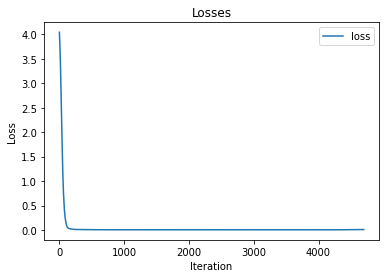

In [10]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

mean classification accuracy=0.6393


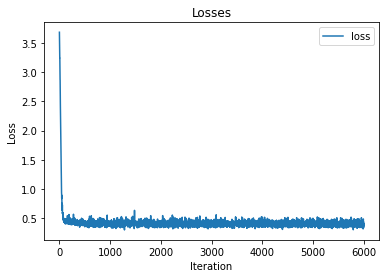

In [ ]:
# orig
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [5]:
class BarlowTwinNet(nn.Module):
    def __init__(self, input_dim=1, latent_dim=128, hidden_dim=128):
        super(BarlowTwinNet, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim // 2))

        self.features = nn.Linear(int(hidden_dim // 2), latent_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [10]:
class BarlowTwins(nn.Module):

    def __init__(self, input_dim=3, latent_dim=128, lmbd=1e-2):
        super().__init__()
        self.model = BarlowTwinNet(input_dim=input_dim, 
                                   latent_dim=latent_dim, 
                                   hidden_dim=128)
        self.lmbd = lmbd


    def get_latent(self, x):
        self.eval()
        x = x.to(device)
        latent = self.model(x)
        self.train()
        return latent


    def normalize(self, x):
        return (x - x.mean(0)) / x.std(0)


    def get_parts(self, covariance):
        n = covariance.shape[0]
        diag = torch.diagonal(covariance).add_(-1).pow_(2).sum()
        corners = covariance.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten().pow_(2).sum()
        return diag, corners


    def get_loss(self, x):
        y_a, y_b = torch.chunk(x, 2, dim=1)

        z_a = self.normalize(self.model(y_a))
        z_b = self.normalize(self.model(y_b))

        covariance = z_a.T @ z_b
        covariance.div_(x.shape[0])

        diag, corners = self.get_parts(covariance)
        return diag + self.lmbd * corners


    def fit(self, data_loader, epochs=10, lr=1e-3):

        opt = Adam(self.model.parameters(), lr=lr)
        losses = []

        for epoch in trange(epochs, desc="Training"):
            for batch in tqdm(data_loader, desc="Batch"):
                batch = batch.to(device)
                loss = self.get_loss(batch)
                opt.zero_grad()
                loss.backward()
                opt.step()
                losses.append(loss.item())

        return np.array(losses)


In [11]:
class AugmentedCIFAR10(Dataset):

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.transformation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                  transforms.RandomResizedCrop(size=32),
                                                  transforms.RandomApply([
                                                    transforms.ColorJitter(brightness=0.5, 
                                                                            contrast=0.5, 
                                                                            saturation=0.5, 
                                                                            hue=0.1)
                                                    ], p=0.8),
                                                  transforms.RandomGrayscale(p=0.2),
                                                  transforms.GaussianBlur(kernel_size=9),
                                                  transforms.Normalize((0.5,), (0.5,))])

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return torch.cat([self.transformation(img) for _ in range(2)])

    def __len__(self):
        return len(self.dataset)

In [14]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """


    input_dim = 3
    latent_dim = 128
    batch_size = 256

    # epochs = 20
    epochs = 2
    lr = 5e-4
    lmbd = 1e-2
    
    train_loader = DataLoader(AugmentedCIFAR10(train_data), 
                              batch_size=batch_size, 
                              shuffle=True)

    model = BarlowTwins(input_dim=input_dim, 
                        latent_dim=latent_dim, 
                        lmbd=lmbd).to(device)
    
    losses = model.fit(train_loader, epochs=epochs, lr=lr)
    
    return losses, model.get_latent

Files already downloaded and verified
Files already downloaded and verified


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

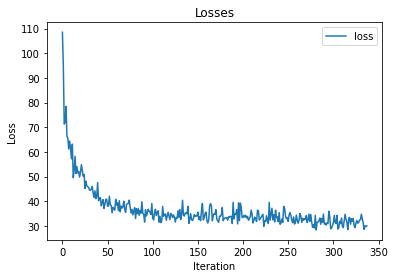

In [17]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)

q2_results(q2, False)
# q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)